# BPM Imputation Strategy

This notebook addresses the missing values in the **BPM (Beats Per Minute)** column of the *Music & Mental Health* dataset. While most features are well-populated, BPM is significantly incomplete and requires special attention before downstream analysis or modeling.

### Objectives:
- Quantify and explore the extent of missing BPM data
- Investigate potential patterns or biases in missingness
- Evaluate candidate imputation strategies based on available features (e.g., Genre, Mood, Frequency)
- Implement and justify a final imputation method
- Assess the impact of imputation on the dataset's integrity and future analyses

By the end of this notebook, all missing BPM values will be imputed using a method that balances accuracy and interpretability, ensuring the dataset is ready for further exploration and modeling.

In [2]:
# Avoids caching source code in order to utilize the latest changes

%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Statistics
import scipy.stats as stats

from music_and_mental_health_survey_analysis.config import RAW_DATA_DIR, FIGURES_DIR

2025-06-03 20:55:07.542 | INFO     | music_and_mental_health_survey_analysis.config:<module>:11 - PROJ_ROOT path is: /home/arsen/Documents/dsc_projects/music_health_survey/music_mental_health_analysis


In [4]:
# Load data

df = pd.read_csv(RAW_DATA_DIR / 'mxmh_survey_results.csv')
df.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


In [5]:
df['BPM'].describe()

count    6.290000e+02
mean     1.589948e+06
std      3.987261e+07
min      0.000000e+00
25%      1.000000e+02
50%      1.200000e+02
75%      1.440000e+02
max      1.000000e+09
Name: BPM, dtype: float64

# Outliers

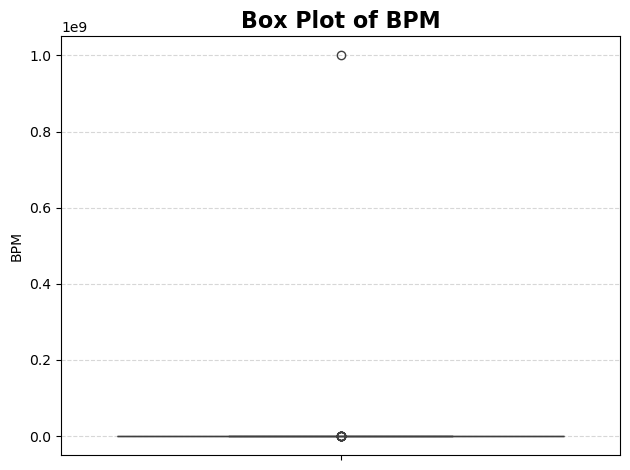

In [6]:
# Visualize BPM using a boxplot

sns.boxplot(df['BPM'])
plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.title("Box Plot of BPM", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

There is **one extreme outlier** which is significantly distorting the distribution of BPM. This outlier will be **dropped**.

In [7]:
# Drop row with max BPM

max_bpm = df['BPM'].max()
df = df[df['BPM'] != max_bpm]

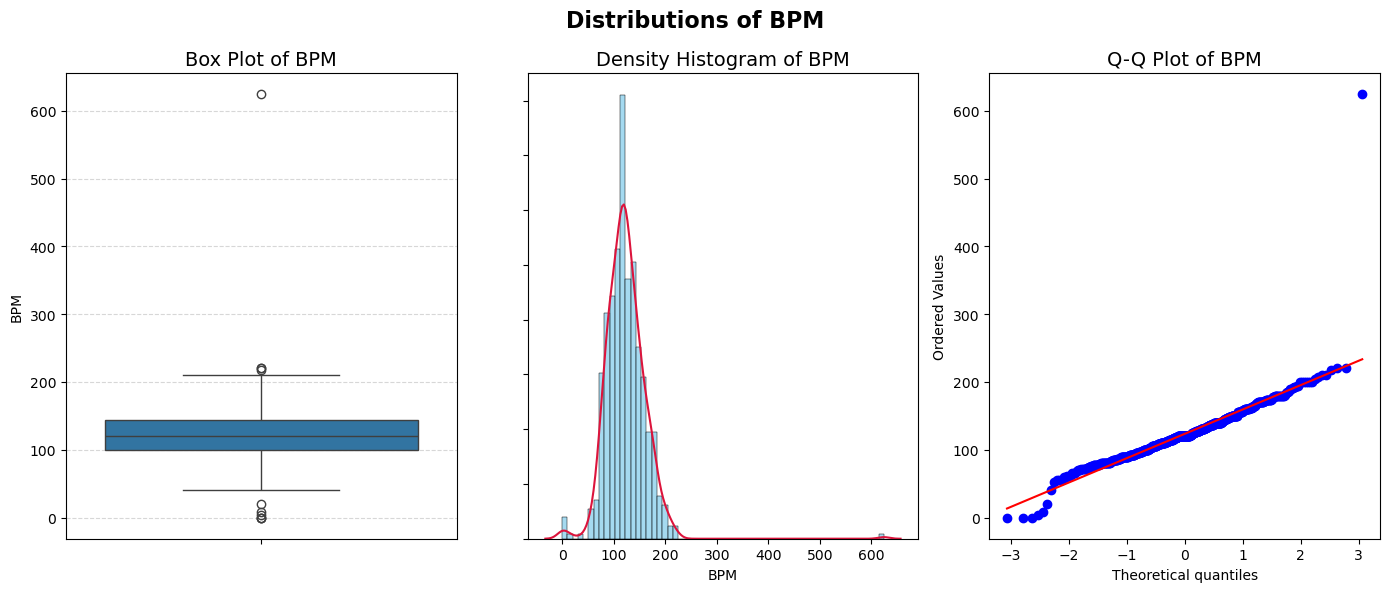

In [8]:
# Plot box plot, histogram, and qq plot to visualize distribution of bpm

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

fig.suptitle('Distributions of BPM', fontsize=16, fontweight='bold')

sns.boxplot(df['BPM'], ax=ax[0])
ax[0].grid(axis='y', alpha=0.5, linestyle='--')
ax[0].set_title("Box Plot of BPM", fontsize=14)

sns.histplot(df['BPM'], ax=ax[1], color='skyblue', stat='density')
sns.kdeplot(df['BPM'], ax=ax[1], color='crimson')
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
ax[1].set_title('Density Histogram of BPM', fontsize=14)

plt.sca(ax[2])
stats.probplot(df['BPM'].dropna(), dist='norm', plot=plt)
ax[2].set_title('Q-Q Plot of BPM', fontsize=14)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'bpm_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

Based on these charts, when stripped of extreme outliers BPM **resembles a normal distribution**. Therefore, we will drop BPMs **outside of the IQR**.

In [9]:
# Calculate IQR
first_quantile = df['BPM'].quantile(q=0.25)
third_quantile = df['BPM'].quantile(q=0.75)
iqr = third_quantile - first_quantile

lower_bound = first_quantile - (1.5 * iqr)
upper_bound = third_quantile + (1.5 * iqr)

# Drop outliers
df = df[(df['BPM'] >= lower_bound) & (df['BPM'] <= upper_bound)]
df['BPM'].describe()

count    618.000000
mean     123.294498
std       31.403228
min       40.000000
25%      100.000000
50%      120.000000
75%      143.000000
max      210.000000
Name: BPM, dtype: float64

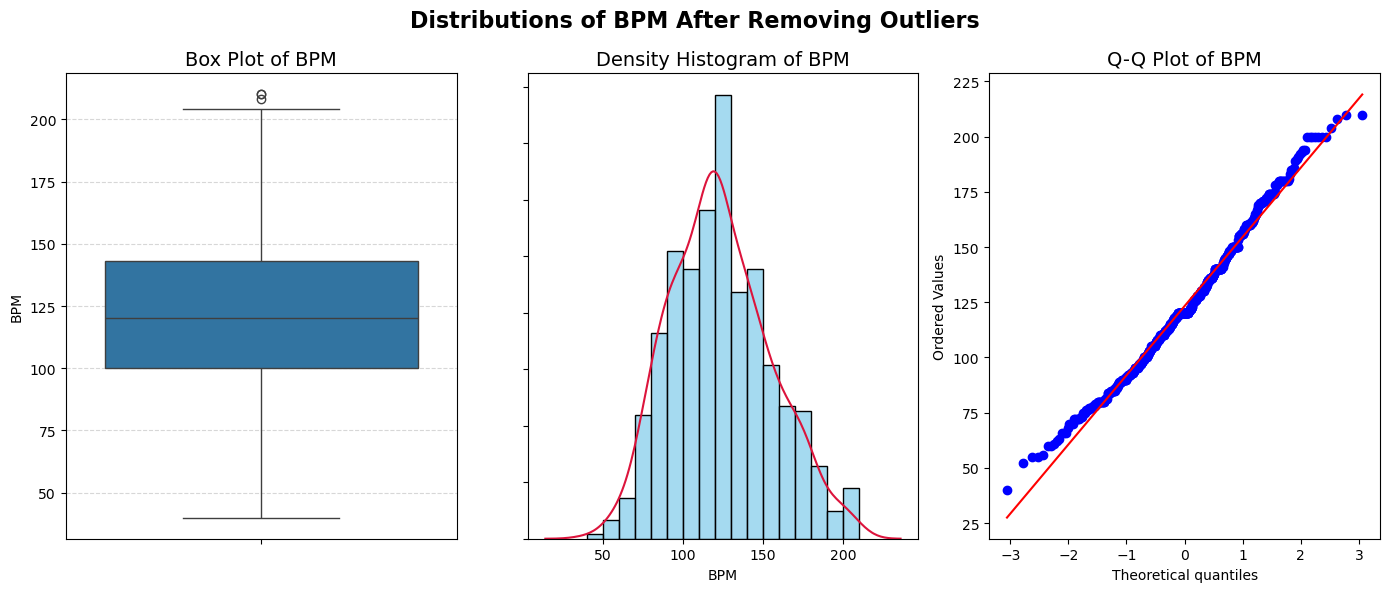

In [10]:
# Plot box plot, histogram, and qq plot to visualize distribution of bpm

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

fig.suptitle('Distributions of BPM After Removing Outliers', fontsize=16, fontweight='bold')

sns.boxplot(df['BPM'], ax=ax[0])
ax[0].grid(axis='y', alpha=0.5, linestyle='--')
ax[0].set_title("Box Plot of BPM", fontsize=14)

sns.histplot(df['BPM'], ax=ax[1], color='skyblue', stat='density')
sns.kdeplot(df['BPM'], ax=ax[1], color='crimson')
ax[1].set_ylabel('')
ax[1].set_yticklabels('')
ax[1].set_title('Density Histogram of BPM', fontsize=14)

plt.sca(ax[2])
stats.probplot(df['BPM'].dropna(), dist='norm', plot=plt)
ax[2].set_title('Q-Q Plot of BPM', fontsize=14)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'clean_bpm_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

- Explored the distribution of `BPM` using a box plot, histogram with KDE, and Q-Q plot.
- Discovered that `BPM` is approximately **normally distributed** with some mild skew and outliers.
- Identified and **removed outliers** based on the **IQR rule** (1.5 * IQR below Q1 or above Q3).

# Imputation

In order to use `KNNImputer`:
- Outliers in `BPM` need to be removed
- Other columns need to be cleaned and ready